In [1]:
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessClassifier
from visualize import *
from calibration import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

NUM_BINS = 10
N = 1000 # takes value from 1 to 10000
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 2
METHOD_NAME = "binary_gp"

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
data = np.genfromtxt("data/cifar100_predictions_dropout.txt")[0:N,:]# 10000*101

In [3]:
p = data[:,1:]
Y_predict = np.argmax(p, axis=1)
Y_true = data[:,0]

# Fit GP to each class

(1000,)
(1000,)
(1000,)
(1000,)


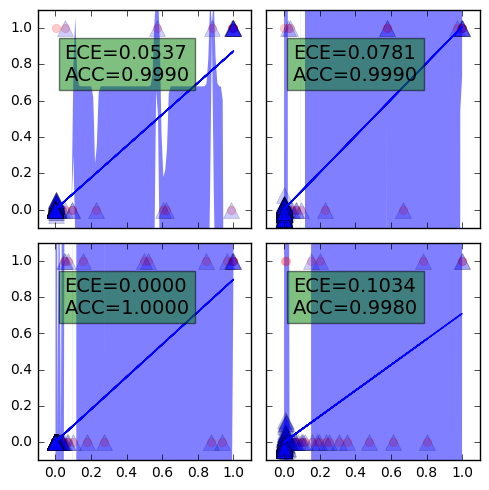

In [4]:
f, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
f.set_figheight(5)
f.set_figwidth(5)
for K in range(NUM_CLASSES_PLOT):
    ax[K/NUM_COL, K%NUM_COL] = gp_regression(ax[K/NUM_COL, K%NUM_COL],
                                             p[:,K],
                                             np.array((Y_true == K)) * 1)
f.tight_layout()
#f.savefig("figures/%s/reliability_per_class.png" % METHOD_NAME)
#f.savefig("figures/%s/reliability_per_class.eps" % METHOD_NAME, format='eps',dpi=1000)
#plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')